In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os


# # Использование класса
# sales_data = ...  # Загрузите данные о продажах
# calendar_data = ...  # Загрузите данные календаря
# prices_data = ...  # Загрузите данные о ценах

# preprocessor = DataPreprocessor(sales_data, calendar_data, prices_data)

class RetailSalesPredictor:
    def __init__(self, sales_data, calendar_data, prices_data):
        self.sales_data = sales_data
        self.calendar_data = calendar_data
        self.prices_data = prices_data
                                                                                # Мы заранее выбрали STORE 1
    def preprocess_data(self, item_id, sales_data, calendar_data, prices_data): # Выбираем товар (item_id) из магазина STORE 1, подаем  df: sales, calendar, price
        item = str(item_id)
        sales = sales_data

        ### Обрабатываем основную таблицу sales_data и отбираем ряд для конкретного товара

        customer = sales[(sales['store_id'] == 'STORE_1') & (sales['item_id'] == f'STORE_1_{item}')]
        customer = pd.merge(customer, calendar_data, on='date_id', how='inner')
        customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
        customer = customer[['ds', 'y']]

        customer['ds'] = pd.to_datetime(customer['ds'])

        ### Обрабатываем праздники

        # Извлекаем даты и названия праздников
        holidays_1 = calendar_data[['date', 'event_name_1']].dropna().rename(columns={'date': 'ds', 'event_name_1': 'holiday'})
        holidays_2 = calendar_data[['date', 'event_name_2']].dropna().rename(columns={'date': 'ds', 'event_name_2': 'holiday'})

        # Объединяем оба набора данных
        holidays = pd.concat([holidays_1, holidays_2])

        # Убедимся, что столбец ds имеет тип datetime
        holidays['ds'] = pd.to_datetime(holidays['ds'])

        # Создание DataFrame с будущими датами праздников
        future_years = [2016, 2017]
        future_holidays = []

        for year in future_years:
            for holiday in holidays['holiday'].unique():
                future_holidays.append({
                    'holiday': holiday,
                    'ds': pd.to_datetime(f"{year}-01-01"),  # Здесь нужно указать соответствующие даты праздников
                    'lower_window': 0,
                    'upper_window': 1
                })

        future_holidays_df = pd.DataFrame(future_holidays)
        # Объединяем текущие и будущие праздники
        all_holidays = pd.concat([holidays, future_holidays_df])

        ###  Обрабатываем цены

        item_prices = prices_data[prices_data['item_id'] == f'STORE_1_{item}'][['wm_yr_wk', 'sell_price']]

        # Убедимся, что wm_yr_wk в формате целого числа
        item_prices['wm_yr_wk'] = item_prices['wm_yr_wk'].astype(int)

        # Переименовываем столбцы для удобства
        item_prices = item_prices.rename(columns={'wm_yr_wk': 'week', 'sell_price': 'price'})

        # Добавляем даты в данные о ценах, если у нас есть календарь с недельным номером и датами
        calendar_data['wm_yr_wk'] = calendar_data['wm_yr_wk'].astype(int)
        item_prices = item_prices.merge(calendar_data[['wm_yr_wk', 'date']], left_on='week', right_on='wm_yr_wk', how='left')
        item_prices = item_prices.rename(columns={'date': 'ds'}).drop(columns=['wm_yr_wk'])

        # Убедимся, что столбец ds имеет тип datetime
        item_prices['ds'] = pd.to_datetime(item_prices['ds'])

        # Убедимся, что столбец ds имеет тип datetime и в customer
        customer['ds'] = pd.to_datetime(customer['ds'])

        # Объединение данных о продажах и ценах
        customer = customer.merge(item_prices[['ds', 'price']], on='ds', how='left')

        return f'STORE_1_{item}', customer, all_holidays
    
    def train_model(self, df, holidays, test_size=30):
        train_data = df.iloc[:-test_size]
        test_data = df.iloc[-test_size:]

        # Создание и обучение модели Prophet с праздниками и регрессором
        model = Prophet(holidays=holidays)
        model.add_regressor('price')

        # Обучение модели
        model.fit(train_data)
        return model, train_data, test_data

    def predict_and_evaluate(self, model, customer, period, test_data):
        # Создание прогноза для тестовой выборки
        future = model.make_future_dataframe(periods=period)
        # Объединяем данные о будущем с будущими ценами (предполагается, что у вас есть прогноз цен или просто используем последние известные цены)
        future = future.merge(customer[['ds', 'price']], on='ds', how='left')

        # Предсказание
        forecast = model.predict(future)

        # Выборка последних 30 дней прогноза
        predicted = forecast[['ds', 'yhat']].tail(period)

        # Метрики точности прогноза
        actual = test_data['y'].values
        predicted_values = predicted['yhat'].values

        # print(len(test_data))
        # print(len(actual))
        # print(len(predicted_values))

        mse = mean_squared_error(actual, predicted_values)
        mae = mean_absolute_error(actual, predicted_values)

        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')

        # Визуализация прогноза
        fig1 = model.plot(forecast)
        plt.show()

        # Визуализация компонентов прогноза
        fig2 = model.plot_components(forecast)
        plt.show()



In [107]:
sales_data = pd.read_csv('shop_sales.csv')  # Загрузите данные о продажах
calendar_data = pd.read_csv('shop_sales_dates.csv')   # Загрузите данные календаря
prices_data = pd.read_csv('shop_sales_prices.csv')   # Загрузите данные о ценах

In [108]:
class_ts = RetailSalesPredictor(sales_data, calendar_data, prices_data)

In [109]:
store_item, customer_table, all_holidays = class_ts.preprocess_data(252, sales_data, calendar_data, prices_data)

In [110]:
model, train_data, test_data = class_ts.train_model(customer_table, all_holidays, test_size = 30)

21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:31 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
customer_table

,ds,y,price
0,2011-01-29,22,1.48
1,2011-01-30,23,1.48
2,2011-01-31,12,1.48
3,2011-02-01,12,1.48
4,2011-02-02,8,1.48
...,...,...,...
1814,2016-01-17,13,1.58
1815,2016-01-18,2,1.58
1816,2016-01-19,8,1.58
1817,2016-01-20,13,1.58


Mean Squared Error: 67.87032946650774
Mean Absolute Error: 6.806235202416954


/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


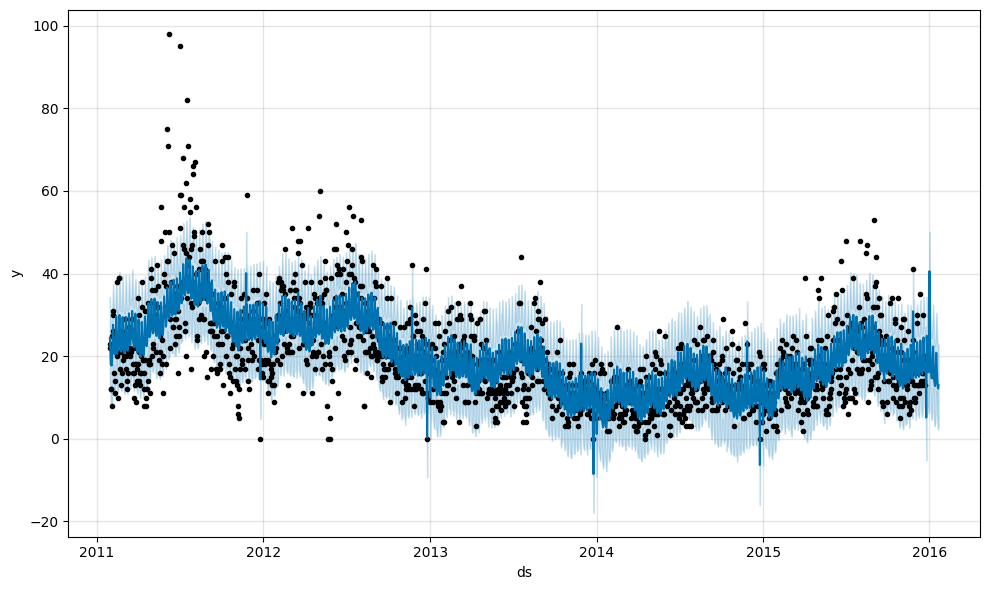

/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/muzafarov/anaconda3/envs/timeseries/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing

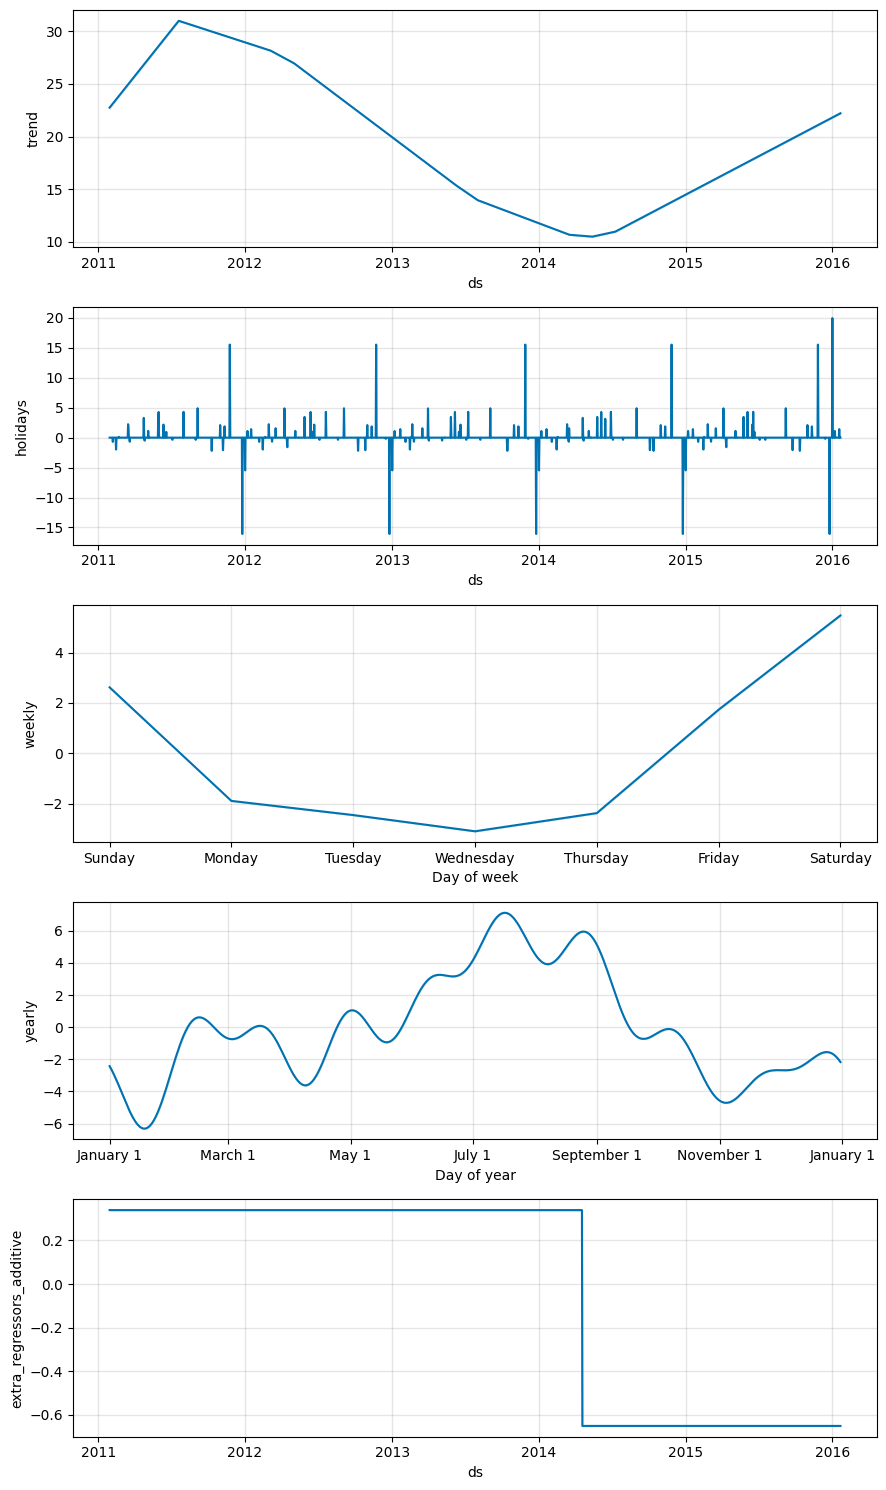

In [104]:
class_ts.predict_and_evaluate(model, customer_table, 30, test_data)